In [1]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd
import torch

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

log_plot = True

#Note: Need to normalize all values

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%time
# Create synthetic data assuming the following values for theta
a_guess = np.array([0,0,-7,1])


Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])

##New Cell

# Evaluate model and add noise based on assumed theta values
# This generates experimental data points
exp_data_doc = "Input_CSVs/Exp_Data/n=5.csv"
exp_data = pd.read_csv(exp_data_doc, header=0,sep=",",index_col=0)
Num_params  = len(exp_data.T)
Xexp = np.array([exp_data.iloc[:,0:Num_params-1]])[0,:]
Yexp = np.array([exp_data.iloc[:,-1]])[0,:]

# print(Xexp[:,0])

CPU times: user 4.79 ms, sys: 2.95 ms, total: 7.74 ms
Wall time: 5.08 ms


/tmp/ipykernel_1026717/3518080186.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour3D(X1, X2, Y, 50, cmap='Reds', label = "True Model")


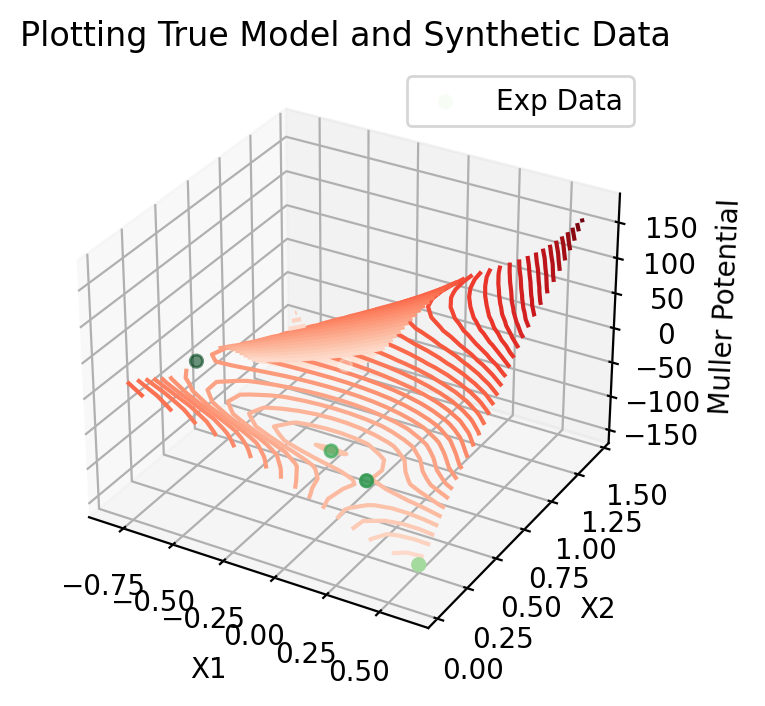

In [3]:
##New Cell

# Evaluate model based on the assumed experimental values
#Create Meshgrid for X1 and X2 and evaluate Y
len_mesh_data = 20
x1 = np.linspace(np.min(Xexp[:,0]),np.max(Xexp[:,0]),len_mesh_data)
x2 = np.linspace(np.min(Xexp[:,1]),np.max(Xexp[:,1]),len_mesh_data)
X1, X2 = np.meshgrid(x1,x2)
X_mesh = np.meshgrid(x1,x2)
# #Creates an array for Y that will be filled with the for loop
# #Initialize y_sim
Y = [] #len_data 

# #Find evey combination of X1/X2 to find the SSE for each combination
#Set constants
A, a, b, c, x0, y0 = Constants

#Calculate y_sim
#Define X1 and X2 (Need a better way do do this without for loops)
#Loop over combinations of X1 X2
for i in range(len_mesh_data):
    for j in range(len_mesh_data):
        Term1 = a*(X1[i,j] - x0)**2
        Term2 = b*(X1[i,j] - x0)*(X2[i,j] - y0)
        Term3 = c*(X2[i,j] - y0)**2
        Y.append( np.sum( A*np.exp(Term1 + Term2 + Term3) ) )
        
#Reshape to correct dimension (Is there an easier wat to do this?)        
Y = np.array(Y).reshape(len_mesh_data,-1)
# print(Y)
# Compare the experiments to the true model
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X1, X2, Y, 50, cmap='Reds', label = "True Model")
ax.scatter3D(Xexp[:,0], Xexp[:,1], Yexp, c=Yexp, cmap='Greens', label = "Exp Data")
ax.legend() #Why won't this show both labels?
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Muller Potential');
plt.title("Plotting True Model and Synthetic Data")
plt.show()


In [4]:
##New Cell

## define function that includes nonlinear model
def model(a_guess, Constants, x):
    '''
        """
    Creates Muller potential values given a guess for "a"
    Parameters
    ----------
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, Independent variable data (exp or pred)
    Returns
    -------
        y_model: ndarray, The simulated Muller potential given the guess
    '''
    #Assert statements check that the types defined in the doctring are satisfied
    
    #Converts parameters to numpy arrays if they are tensors
    if torch.is_tensor(a_guess)==True:
        a_guess = a_guess.numpy()
        
    if isinstance(a_guess, pd.DataFrame):
        a_guess = a_guess.to_numpy()
    
    #Initialize y_sim, set len_data and dim_x
    len_x_shape = len(x.shape) #Will tell us whether we're looking at Xexp or Xmesh
        
    if len_x_shape < 3:
        len_x_data = x.shape[0]
        y_model = np.zeros(len_x_data)
        
    else:
        len_x_data = x.shape[1]
        y_model = np.zeros((len_x_data, len_x_data))

    #Iterates over Xexp to find the y for each combination
    for i in range(len_x_data):
        #Set dig out values of a from train_p
        #Set constants to change the a row to the index of the first loop
        A, a, b, c, x0, y0 = Constants
        len_a = a.shape[0]
        a = a_guess
#         print(a)

        #Calculate y_sim
        if len_x_shape < 3:
            X1, X2 = x[i,0], x[i,1]
            Term1 = a*(X1 - x0)**2
            Term2 = b*(X1 - x0)*(X2 - y0)
            Term3 = c*(X2 - y0)**2
            y_model[i] = np.sum(A*np.exp(Term1 + Term2 + Term3) )
        else:
        #loop over all i and j
            X1, X2 = x[0], x[1]
            for i in range(len_x_data):
                for j in range(len_x_data):
                    Term1 = a*(X1[i,j] - x0)**2
                    Term2 = b*(X1[i,j] - x0)*(X2[i,j] - y0)
                    Term3 = c*(X2[i,j] - y0)**2
                    y_model[i,j] = ( np.sum( A*np.exp(Term1 + Term2 + Term3) ) )
   
    if not len_x_shape < 3:
        y_model = y_model.reshape(len_x_data, -1)
    
    return y_model

# print(model(a_guess,Constants,Xexp))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(a_guess, Constants, x, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    
    error = y - model(a_guess, Constants, x); #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

# print(regression_func(a_guess, Constants, Xexp, Yexp))

#Look up FFO Code to write Pseudo Code for this
#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(xx, yy, x, y):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all Theta1 values
            
        yy: An D X N array of all Theta2 values
        theta: parameter vector
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    sse = np.zeros([len(xx),len(yy)])
    
    for i in range(len(xx)):
        for j in range(len(yy)):
            theta = np.array([xx[i][j],yy[i][j]])
            sse[i][j] = sum((y - model(theta,x))**2) 
    
    return sse

In [5]:

## specify initial guess
a0 = a_guess
#Define # of dimensions
try:
    d = a_guess.shape[0]*a_guess.shape[1]
except:
    d = a_guess.shape[0]
## specify bounds
# first array: lower bounds
# second array: upper bounds
lower = np.repeat(-np.inf, d)
upper = np.repeat(np.inf, d)
bounds = (lower, upper) 

## use least squares optimizer in scipy
# argument 1: function that takes theta as input, returns residual
# argument 2: initial guess for theta
# optional arguments 'bounds': bounds for theta
# optional arugment 'args': additional arguments to pass to residual function
# optional argument 'method': select the numerical method
#   if you want to consider bounds, choose 'trf'
#   if you do not want to consider bounds, try either 'lm' or 'trf'
Solution = optimize.least_squares(regression_func, a0 ,bounds=bounds, method='trf',args=(Constants, Xexp, Yexp))

Soln = Solution.x
print("a = ",Soln)


a =  [-1.00000054 -0.99999948 -6.50002018  0.7       ]


/tmp/ipykernel_1026717/3144042359.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour3D(X1_pred, X2_pred, Y_pred, 50, cmap='Reds', label = "$y_{sim}$")
/tmp/ipykernel_1026717/3144042359.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour3D(X1, X2, Y, 50, cmap='Blues', label = "$y_{true}$")


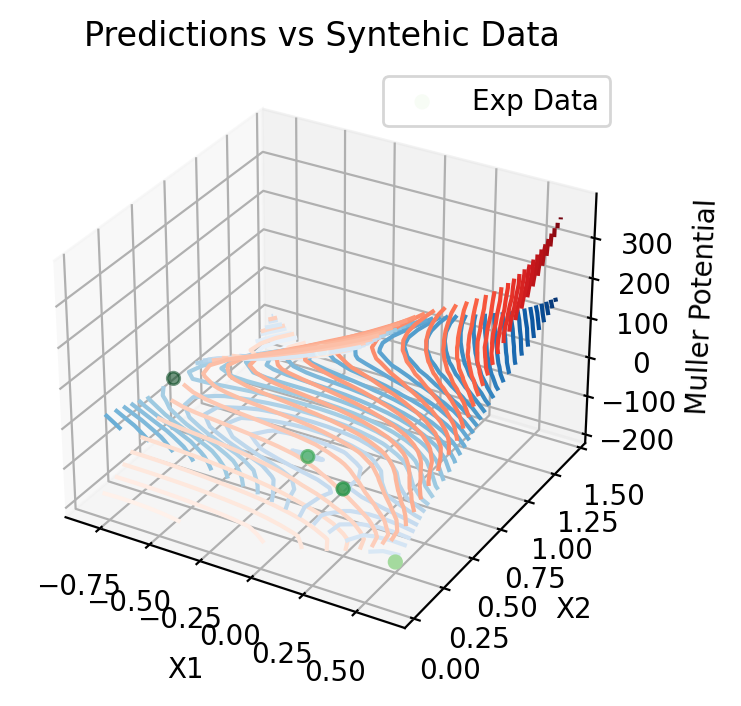

In [6]:
#New Cell
X1_pred, X2_pred = np.meshgrid(x1,x2)
X_pred = np.array(np.meshgrid(x1,x2))
Y_pred = model(a_guess, Constants, X_pred)

# create plot and compare predictions and experiments
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X1_pred, X2_pred, Y_pred, 50, cmap='Reds', label = "$y_{sim}$")
ax.contour3D(X1, X2, Y, 50, cmap='Blues', label = "$y_{true}$")
ax.scatter3D(Xexp[:,0], Xexp[:,1], Yexp, c=Yexp, cmap='Greens', label = "Exp Data")
ax.legend() #Why won't this show both labels?
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Muller Potential');
plt.title("Predictions vs Syntehic Data")
plt.show()

# plt.savefig("Figures/sim_true_comp.png",dpi=300)
plt.show()

(5, 2)
(2, 20, 20)
SSE =  5693.471143463445


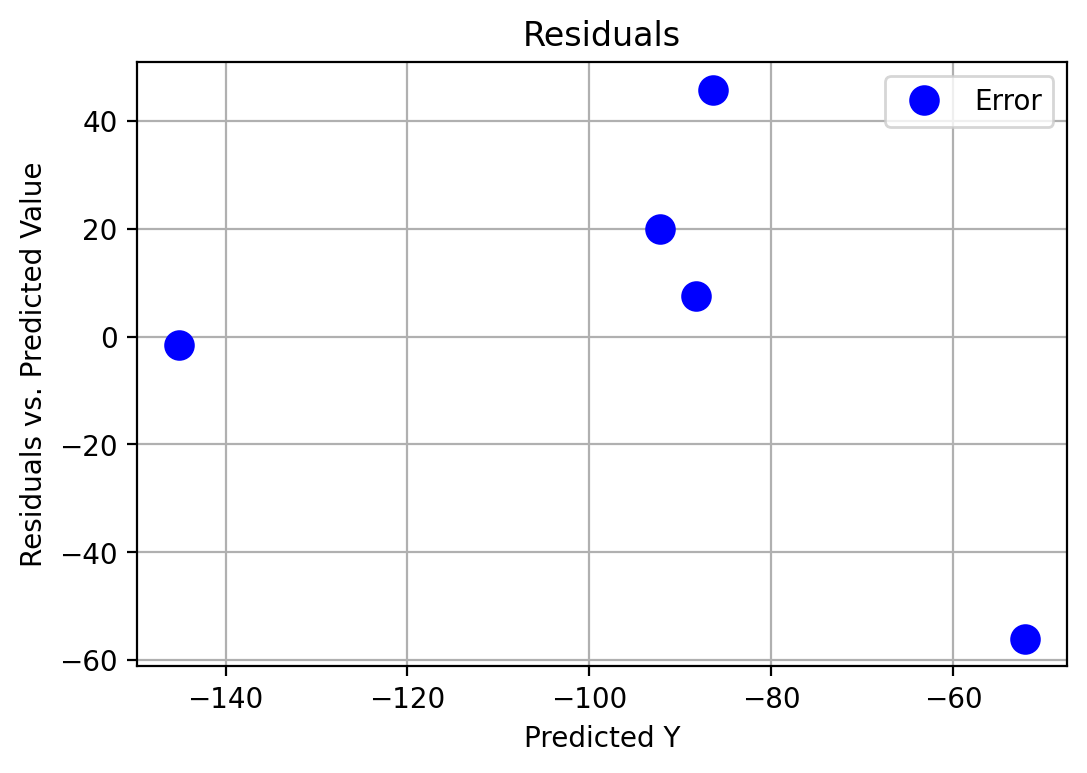

In [7]:
#Plot error
Y_pred_of_exp = model(a_guess, Constants, Xexp)
error = (Yexp - Y_pred_of_exp)
print("SSE = ", np.sum(error**2))
plt.plot(Y_pred_of_exp,error,"b.",markersize=20, label = "Error")
plt.title("Residuals")
plt.xlabel('Predicted Y')
plt.ylabel('Residuals vs. Predicted Value')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
#Jacobian and Uncertainty Analysis
print("Jacobian =\n")
print(Solution.jac)
sigre = (error.T @ error)/(len(error) - 2)
Sigma_theta2 = sigre * np.linalg.inv(Solution.jac.T @ Solution.jac)
print("Covariance matrix:\n",Sigma_theta2)

Jacobian =

[[-0.00000000e+00  3.19290161e-03  5.68045097e-01 -4.33138466e+00]
 [ 8.26894603e+00  2.46674538e-01  5.39924704e-05 -2.29258690e+01]
 [ 2.44670699e+01  2.83710480e+00 -0.00000000e+00 -1.87786990e+02]
 [ 5.16638955e-01  2.97214394e+01  1.29088470e+00 -5.27911186e-01]
 [ 2.69233597e+01  3.09106255e+00 -0.00000000e+00 -5.34224968e+01]]
Covariance matrix:
 [[ 5.08671028e+00 -1.73852542e+00  3.30761973e+01  7.89054560e-01]
 [-1.73852542e+00  1.32736924e+01 -2.55549927e+02 -5.36532371e-02]
 [ 3.30761973e+01 -2.55549927e+02  5.87422589e+03  1.04703306e+00]
 [ 7.89054560e-01 -5.36532371e-02  1.04703306e+00  1.75172553e-01]]
